# Pandas Excel Reference

## Recreating excel functions with Pandas

Below is a list of the "Top 25 Useful Advanced Excel Functions and Formulas" I found on a web site. You are probably familiar with these functions in excel, we will see how to replicate these actions on a pandas datafame.


https://www.educba.com/advanced-excel-formulas-and-functions/


##### The list:
 1. VLOOKUP
 2. SUM
 3. MAX & MIN
 4. IF (crieria, true, false, value)
 5. SUMIF
 6. COUNTIF
 7. AND
 8. OR
 9. LEFT
 10. RIGHT
 11. CONCATENATION
 12. ROUND
 13. PROPER(capitalize)
 14. NOW
 15. Change the case
 16. TRIM
 17. Customized Min, Max (ex: get fifth highest amount large data pool)
 18. CHOOSE
 19. REPT – how many times a character is in a cell
 20. TYPE
 21. RANDBETWEEN
 22. CONVERT (unit conversion)
 23. PV
 24. Timeunctions (WEEKNUM, WORKDAY, NETWORKDAYS, YEARFRAC, EDATE)
 25. Mathematical functions (aggregate, difference, quyotient, LCM, GCD)
 
##### Others that should have made the list:
 
 26. SUMPRODUCT
 27. INDEX
 28. MATCH
 29. PIVOT
 30. SORT
 
I am going to split these 30 functions up based on different categories.

I. Basic Mathematical Functions (2, 3, 25, 12, 22, 23)
    - Sum, min, max, quotient, LCM, GCD, difference, round, convert, pv
    
II. Mathematical Functions with Conditions (4, 5, 6, 7, 8, 17, 26, 30)
    - Sumif(s), countif(s), sumproduct, if, customized min/max, sort

III. String Calculations (8, 9, 10, 11, 13, 15, 16, 19)
    - left, right, concatenate, proper, change case, trim, rept

IV. Random Variables (18, 21)
    - choose, randbetween 
        
V. Index and Lookups (1, 20, 27, 28, 29)
    - Vlookup, type, index, match, pivot

VI. Date and Time functions (14, 24)
    - Now, weeknum, workday, networkdays, yearfrac, edate



#### We will need to use two different dataframes to test all of these functions.
Some of the functions, vlookup, for example, only work when there is a unique identifier, such as a column of IDs or trade numbers. The student test scores database has no unique identifier for each student besides the index, which would not be appropriate to display a vlookup. (If you know the index, then you don't need to use vlookup.)

We will use the following dataframes
 - df_scores = test score database
 - df_FX_options = static FX option database from FX_DERIVATIVES_ALL database./


___
## O. Loading and preparing the dataset

##### Standard import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##### Load and clean the Student Performance database
In Tutorial #5 we cleaned this database by replacing column names with shorter versions, creating boolean variables from text and creating a ranking for the parents education variable. We will do the same thing here, but with a function (actually 2 nested functions) that performs these changes.

In [2]:
# load up the Students Performance Database
df_test= pd.read_csv('../data/StudentsPerformance.csv')

In [3]:
def clean_student_df(df):
    # rename the columns
    df = df.rename(columns = {'race/ethnicity': 'race',
                             'parental level of education': 'parent_ed',
                             'test preparation course': 'test_prep',
                              'math score': 'math',
                              'reading score': 'reading',
                              'writing score': 'writing'
                             })

    # clean up the group variable entries
    df[['group', 'race']] = df['race'].str.split(' ', expand=True)
    df = df.drop(columns = ['group'])
    
    # create boolean variable 'free_lunch'
    df.loc[df['lunch']=='free/reduced', 'free_lunch'] = 1
    df['free_lunch'].fillna(0, inplace=True)
    df['free_lunch'] = df['free_lunch'].astype(bool)


    # function used to create boolean variable 'prep_done'
    original_column = 'test_prep'
    column_entry = 'completed'
    new_column = 'prep_done'
    df = create_bool_column(df, original_column, column_entry, new_column)

    # Creating ordinal ranking for parents education
    list_education = ['some high school', 
                     'high school',
                     'some college',
                     "associate's degree",
                     "bachelor's degree",
                     "master's degree"]    
    df['ed_rank']=0
    for i, ed in enumerate(list_education):
        df.loc[df['parent_ed']==ed, 'ed_rank'] = i
    
    # dropping unnecessart columns
    df = df.drop(columns = ['lunch', 'test_prep'])
    
    return df

In [4]:
def create_bool_column(df, original_column, column_entry, new_column):
    '''
    this function creates a boolean column based on the data in the df[original_column]
    Inputs
        df: a dataframe containing a column with the string in original_column
        original_column: a string with the label of a column in df
        column_entry: a string with one of the boolean strings in df[original_column]
        new_column: a string that will be the new boolean column
    
    '''
    df.loc[df[original_column]==column_entry, new_column] = 1
    df[new_column].fillna(0, inplace=True)
    df[new_column] = df[new_column].astype(bool)
    return df


##### Below we are running the df_test dataframe through the clean_student_df function

In [5]:
df_test = clean_student_df(df_test)

##### Testing the final dataframe using sample

In [6]:
df_test.sample(10)

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank
388,female,D,high school,62,64,64,False,False,1
649,female,D,some college,69,79,81,False,True,2
883,male,D,bachelor's degree,55,46,44,True,False,4
926,male,E,associate's degree,64,56,52,True,False,3
768,female,D,some high school,68,71,75,False,False,0
643,female,E,high school,74,79,80,False,True,1
617,male,D,bachelor's degree,88,78,83,False,False,4
888,female,D,some college,69,65,74,True,False,2
509,female,C,bachelor's degree,86,92,87,False,False,4
567,female,D,master's degree,61,71,78,True,True,5


OK so we have a clean dataset, let's get to it!

---
## I. BASIC MATHEMATICAL FUNCTIONS

### Sum, mean, max, min
These are pandas methods, so we just need to call them on a particular column. 

Note: If we call them on the entire dataframe, we will get a pandas series returned. The series will have an index that contains the numeric column names and the values will be the calculated value for each series. (If that is unclear, insert a column and try it!)

In [7]:
reading_sum = df_test['reading'].sum()
math_mean = df_test['math'].mean()
writing_max = df_test['writing'].max()
math_min = df_test['math'].min()

print("Here is the sum of all reading scores: ", reading_sum)
print("Here is the average of all math scores: ", math_mean)
print("The highest writing score was ", writing_max)
print("The worst math score was ", math_min)

Here is the sum of all reading scores:  69169
Here is the average of all math scores:  66.089
The highest writing score was  100
The worst math score was  0


### Quotient (this is the integer part of division. Ex: 5/2 = 2.5, so the quotient = 2, the remainder (mod)= 1)

There are multiple different division options in excel and python. 
    - Division (like you learned in 4th grade that will return a decimal) use /
    - Division to get the integer part of the division use df.floordiv()
    - To recover the remainder (modulo) use df.mod()

In [8]:
df_test['div'] = df_test['math'] / df_test['writing']
df_test['int_div'] = df_test['math'].floordiv(df_test['writing'])
df_test['modulo'] = df_test['math'].mod(df_test['writing'])
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo
0,female,B,bachelor's degree,72,72,74,False,False,4,0.972973,0,72
1,female,C,some college,69,90,88,False,True,2,0.784091,0,69
2,female,B,master's degree,90,95,93,False,False,5,0.967742,0,90
3,male,A,associate's degree,47,57,44,True,False,3,1.068182,1,3
4,male,C,some college,76,78,75,False,False,2,1.013333,1,1


### Least Common Multiple (LCM) and Greatest Common Denominator (GCD)

Python has a math module that has many different mathematical functions. You can find a listing of them here.

https://docs.python.org/3/library/math.html

Numpy also has a long list of mathematical functions. You can find a listing of them here.

https://numpy.org/doc/stable/reference/routines.math.html

So this is not pandas, but you can use np and math functions on the columns in pandas.


In [9]:
# Greatest Common Denominator
df_test['GCD'] = np.gcd(df_test['math'], df_test['ed_rank'])
df_test['LCM'] = np.lcm(df_test['math'], df_test['ed_rank'])
df_test.sample(10)

# Note: The zeros make this strange, but let's ignore that for now...

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM
293,female,E,bachelor's degree,65,73,75,False,False,4,0.866667,0,65,1,260
164,female,E,master's degree,81,92,91,False,False,5,0.890110,0,81,1,405
38,female,D,associate's degree,75,90,88,True,True,3,0.852273,0,75,3,75
559,male,D,some high school,73,66,62,False,False,0,1.177419,1,11,73,0
686,male,E,some college,85,75,68,False,True,2,1.250000,1,17,1,170
468,female,A,high school,77,88,85,True,True,1,0.905882,0,77,1,77
182,female,E,high school,50,50,47,False,False,1,1.063830,1,3,1,50
30,female,D,some college,69,74,74,False,False,2,0.932432,0,69,1,138
478,female,D,master's degree,55,64,70,False,False,5,0.785714,0,55,5,55
528,female,D,bachelor's degree,29,41,47,True,False,4,0.617021,0,29,1,116


### Round
Numpy has several rounding functions. The three most commonly used are
    - np.round(x, decimals) will round to the number of decimals
    - np.rint(x) will round to the nearest integer
    - np.floor(x) will round down to the nearest integer
    - np.ceil(x) will round up to the nearest integer

In [10]:
df_test['round_2'] = np.round(df_test['div'], 2)
df_test['round_int'] = np.rint(df_test['div'])
df_test['round_up'] = np.ceil(df_test['div'])
df_test['round_down'] = np.floor(df_test['div'])
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down
0,female,B,bachelor's degree,72,72,74,False,False,4,0.972973,0,72,4,72,0.97,1.0,1.0,0.0
1,female,C,some college,69,90,88,False,True,2,0.784091,0,69,1,138,0.78,1.0,1.0,0.0
2,female,B,master's degree,90,95,93,False,False,5,0.967742,0,90,5,90,0.97,1.0,1.0,0.0
3,male,A,associate's degree,47,57,44,True,False,3,1.068182,1,3,1,141,1.07,1.0,2.0,1.0
4,male,C,some college,76,78,75,False,False,2,1.013333,1,1,2,76,1.01,1.0,2.0,1.0


### Convert
Excel convert will work as a pee-chee folder. (Do all of you know what that is???) 

OK History Lesson here for the less-old Treasury members. In the 70's (before the invention of the Trapper Keeper) there was only one school supply in the drug store. It was the Pee Chee folder. It came in one color and I spent the majority of elementary school coloring the tennis player's underwear. The most useful thing about the Pee-Chee folder was that it had a conversion table inside. Before the internet, this was the only place you could find this information without pulling down a 20 year encyclopedia (with several letters missing) from the living room shelf. OK, you also probably don't know what an encyclopedia is either. (It was wikipedia, but way more outdated).

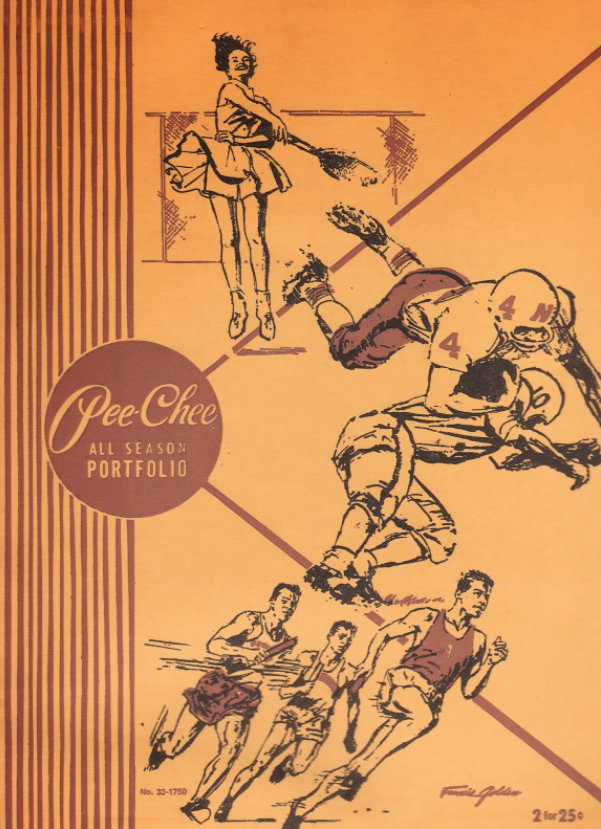
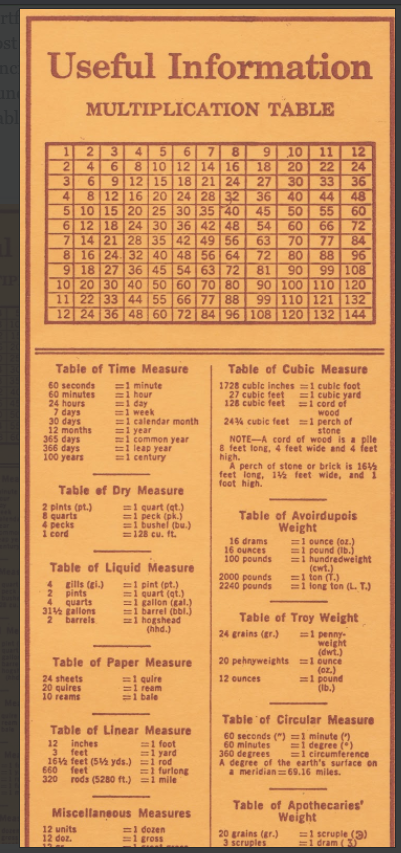

Pandas does not have a 'convert' function, but there are several python modules that can do this in python. I would recommend downloading the 'pint' module for python.

https://pint.readthedocs.io/en/0.10.1/

### Present Value Calculations

 While this is not related to pandas, numpy has you covered.
 
 np.pv(rate, nper, pmt, fv=0, when='end')
 

In [11]:
# Present value of 100/month for 3 years at 5%.
pv_100_month_3_yrs = np.pv(.05/12, 36, 100)
pv_100_month_3_yrs

-3336.5701283740705

### Math Calculations with 1 condition

Starting with 1 condition (like sumif or countif) and walking through it slowly.

##### Suppose we want the average math score for everyone with a free lunch.

Note: I am copying the dataframe here with a boolean mask on 'free_lunch' being true.

In [12]:
df_free_lunch = df_test[df_test['free_lunch']==True].copy()

In [13]:
free_lunch_math_mean = df_free_lunch['math'].mean()
print("The average math score for students with a free lunch was ",free_lunch_math_mean)

The average math score for students with a free lunch was  58.92112676056338


#### The shortcut is to combine these two lines into one statement

This is how you will usually see conditional calculations. It is called 'chaining'.
We know from above that the 'df_test[df_test['free_lunch']=='True] returns a dataframe with the same column names as the df_test dataframe. We are going to reference the 'math' column directly and then call the pandas mean method on that column in one line.

In [14]:
free_lunch_math_mean = df_test[df_test['free_lunch']==True]['math'].mean()

print("The average math score for students with a free lunch was ",free_lunch_math_mean)

The average math score for students with a free lunch was  58.92112676056338


##### NOTE: I dropped the copy in this case because it is not necessary to keep the dataframe for further calculations.

Other Examples:

In [15]:
# Did completing the prep work lead to a lower standard deviation of math scores?
studied_math_std = df_test[df_test['prep_done']==True]['math'].std()
partied_math_std = df_test[df_test['prep_done']==False]['math'].std()

print("Standard deviation of math scores for students who completed prep work: ", studied_math_std)
print("Standard deviation of math scores for students who partied: ", partied_math_std)

Standard deviation of math scores for students who completed prep work:  14.444699225388481
Standard deviation of math scores for students who partied:  15.192375639272065


In [16]:
# Did completing the prep work lead to a lower min score for writing?
studied_writing_min = df_test[df_test['prep_done']==True]['writing'].min()
partied_writing_min = df_test[df_test['prep_done']==False]['writing'].min()

print('Worst bookworm writing score: ', studied_writing_min)
print('Worst hung-over writing score: ', partied_writing_min)

Worst bookworm writing score:  36
Worst hung-over writing score:  10


##### This chaining will work with any mathematical calculations that are a method in pandas.

### Math calculations with multiple conditions
This is equivalent to a sumifs or countifs function in excel.

To use multiple conditions, we can use the 'AND' (also '&') and 'OR' (also '|')

We need to include each condition in parenthesis and put the 'and' statement, here '&' in between them.

In [17]:
# Mean math scores for female students that had a free lunch versus the female students who paid for their lunch
mean_female_free_lunch = df_test[(df_test['gender']=='female') & (df_test['free_lunch']==True)]['math'].mean()
mean_female_expensive_lunch= df_test[(df_test['gender']=='female') & (df_test['free_lunch']==False)]['math'].mean()

print('Mean math score for females that had a free lunch: ', mean_female_free_lunch)
print('Mean math score for females without a free lunch: ', mean_female_expensive_lunch)


Mean math score for females that had a free lunch:  55.81481481481482
Mean math score for females without a free lunch:  68.12462006079028


##### NOTE: True and False are NOT strings. This tends to cause confusion sometimes.
The 'True' can be a string if the column is an object data type. If it is boolean, then the True entry is a condition (not a string).

##### NOTE: To do count or countif, simply use the boolean masks with the length (len) function. This will tell you how many rows.
The len function is NOT a method. It is a function, so we need to put it at the beginning of our boolean masks!

In [18]:
count_male_free_lunch_studiers = len(df_test[(df_test['gender']=='male') &
                                        (df_test['free_lunch']==True) &
                                        (df_test['prep_done']==True)])
count_male_free_lunch_studiers

61

I think this looks messy. Well actually not messy, but just different than the way we normally use boolean masks with a method. Another alternative is to call the 'shape' attribute on the dataframe. Shape will return a tuple, with the number of rows, then the number of columns. We can call the first (zero index) element from this tuple with square brackets [ ] directly.

In [19]:
count_male_free_lunch_studiers = df_test[(df_test['gender']=='male') &
                                        (df_test['free_lunch']==True) &
                                        (df_test['prep_done']==True)].shape[0]
count_male_free_lunch_studiers

61

### Math Calculations with Multiple Conditions using OR

We already looked at AND, so now let's look at doing this with OR (since it was #8 on the list)

Suppose we want to see the average math score based on a students whose parents earned an associate degree, bachelor's degree or a master's degree. Suppose further we are only interested in students that completed the test prep course.

In [20]:
mean_prep_parents_degree = df_test[(df_test['prep_done']==True) &
                                  (df_test['parent_ed']=="associate's degree") |
                                  (df_test['parent_ed']=="bachelor's degree") |
                                  (df_test['parent_ed']=="master's degree")]['math'].mean()
mean_prep_parents_degree

70.24324324324324

### If calculations

In excel the format for if functions is if(condition, result if true, result if false).

This is the same as pandas if we use the np.where function. The syntax is np.where(column you are testing with condition, value if true, value if false)


In [21]:
# Cost of Admission on Ladie's night
df_test['cost_of_admission'] = np.where(df_test['gender']=='female', 3, 5)
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
0,female,B,bachelor's degree,72,72,74,False,False,4,0.972973,0,72,4,72,0.97,1.0,1.0,0.0,3
1,female,C,some college,69,90,88,False,True,2,0.784091,0,69,1,138,0.78,1.0,1.0,0.0,3
2,female,B,master's degree,90,95,93,False,False,5,0.967742,0,90,5,90,0.97,1.0,1.0,0.0,3
3,male,A,associate's degree,47,57,44,True,False,3,1.068182,1,3,1,141,1.07,1.0,2.0,1.0,5
4,male,C,some college,76,78,75,False,False,2,1.013333,1,1,2,76,1.01,1.0,2.0,1.0,5


### Custom min/max functions and SORT

Pandas has methods that will return the largest or smallest n elements from a dataframe column or will return all columns for the n largest or smallest elements of a particular column

In [22]:
top_15 = df_test['math'].nlargest(15)
top_15

149    100
451    100
458    100
623    100
625    100
916    100
962    100
114     99
263     99
306     99
104     98
712     98
934     98
34      97
179     97
Name: math, dtype: int64

In [23]:
# you can also call this to return the entire dataframe by calling the method on the dataframe and 
# specifying the column in the method
df_largest_math = df_test.nlargest(15, ['math'])
df_largest_math

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
149,male,E,associate's degree,100,100,93,True,True,3,1.075269,1,7,1,300,1.08,1.0,2.0,1.0,5
451,female,E,some college,100,92,97,False,False,2,1.030928,1,3,2,100,1.03,1.0,2.0,1.0,3
458,female,E,bachelor's degree,100,100,100,False,False,4,1.000000,1,0,4,100,1.00,1.0,1.0,1.0,3
623,male,A,some college,100,96,86,False,True,2,1.162791,1,14,2,100,1.16,1.0,2.0,1.0,5
625,male,D,some college,100,97,99,False,True,2,1.010101,1,1,2,100,1.01,1.0,2.0,1.0,5
916,male,E,bachelor's degree,100,100,100,False,True,4,1.000000,1,0,4,100,1.00,1.0,1.0,1.0,5
962,female,E,associate's degree,100,100,100,False,False,3,1.000000,1,0,1,300,1.00,1.0,1.0,1.0,3
114,female,E,bachelor's degree,99,100,100,False,True,4,0.990000,0,99,1,396,0.99,1.0,1.0,0.0,3
263,female,E,high school,99,93,90,False,False,1,1.100000,1,9,1,99,1.10,1.0,2.0,1.0,3
306,male,E,some college,99,87,81,False,True,2,1.222222,1,18,1,198,1.22,1.0,2.0,1.0,5


##### We can also return an index to the largest and smallest items in a dataframe based on a specific column

The simplist way to do this is by sorting the dataframe by a numeric column and getting the index

In [25]:
df_test = df_test.sort_values(by=['math'], ascending=False)
df_test.head(10)

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
149,male,E,associate's degree,100,100,93,True,True,3,1.075269,1,7,1,300,1.08,1.0,2.0,1.0,5
962,female,E,associate's degree,100,100,100,False,False,3,1.000000,1,0,1,300,1.00,1.0,1.0,1.0,3
451,female,E,some college,100,92,97,False,False,2,1.030928,1,3,2,100,1.03,1.0,2.0,1.0,3
623,male,A,some college,100,96,86,False,True,2,1.162791,1,14,2,100,1.16,1.0,2.0,1.0,5
625,male,D,some college,100,97,99,False,True,2,1.010101,1,1,2,100,1.01,1.0,2.0,1.0,5
458,female,E,bachelor's degree,100,100,100,False,False,4,1.000000,1,0,4,100,1.00,1.0,1.0,1.0,3
916,male,E,bachelor's degree,100,100,100,False,True,4,1.000000,1,0,4,100,1.00,1.0,1.0,1.0,5
263,female,E,high school,99,93,90,False,False,1,1.100000,1,9,1,99,1.10,1.0,2.0,1.0,3
114,female,E,bachelor's degree,99,100,100,False,True,4,0.990000,0,99,1,396,0.99,1.0,1.0,0.0,3
306,male,E,some college,99,87,81,False,True,2,1.222222,1,18,1,198,1.22,1.0,2.0,1.0,5


In [26]:
top_10 = df_test.index[0:10]
top_10

Int64Index([149, 962, 451, 623, 625, 458, 916, 263, 114, 306], dtype='int64')

In [27]:
# We can do this is one line (here we will take the lowest 10 math scores)
worst_10 = df_test.sort_values(by=['math'], ascending=True).index[0:10]
worst_10

Int64Index([59, 980, 17, 787, 145, 842, 338, 466, 91, 363], dtype='int64')

In [28]:
df_test.tail()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
145,female,C,some college,22,39,33,True,False,2,0.666667,0,22,2,22,0.67,1.0,1.0,0.0,3
787,female,B,some college,19,38,32,False,False,2,0.593750,0,19,1,38,0.59,1.0,1.0,0.0,3
17,female,B,some high school,18,32,28,True,False,0,0.642857,0,18,18,0,0.64,1.0,1.0,0.0,3
980,female,B,high school,8,24,23,True,False,1,0.347826,0,8,1,8,0.35,0.0,1.0,0.0,3
59,female,C,some high school,0,17,10,True,False,0,0.000000,0,0,0,0,0.00,0.0,0.0,0.0,3


In [35]:
# OK now lets get back to the original order by sorting by the index
df_test = df_test.sort_index()
df_test.head(5)

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
0,female,B,bachelor's degree,72,72,74,False,False,4,0.972973,0,72,4,72,0.97,1.0,1.0,0.0,3
1,female,C,some college,69,90,88,False,True,2,0.784091,0,69,1,138,0.78,1.0,1.0,0.0,3
2,female,B,master's degree,90,95,93,False,False,5,0.967742,0,90,5,90,0.97,1.0,1.0,0.0,3
3,male,A,associate's degree,47,57,44,True,False,3,1.068182,1,3,1,141,1.07,1.0,2.0,1.0,5
4,male,C,some college,76,78,75,False,False,2,1.013333,1,1,2,76,1.01,1.0,2.0,1.0,5


___
## III. String Based Functions/Calculations

There are several items on the list that deal with strings. We have seen many of these in prior tutorials, but we can address them here.

##### LEFT & RIGHT
Strings in python can be indexed using the square brackets [ ], and column data in python that are strings (type=object) can as well.

In [134]:
left_2 = df_test['parent_ed'].str[:2]
left_2

0      ba
1      so
2      ma
3      as
4      so
       ..
995    ma
996    hi
997    hi
998    so
999    so
Name: parent_ed, Length: 1000, dtype: object

In [135]:
right_3 = df_test['parent_ed'].str[-3:]
right_3

0      ree
1      ege
2      ree
3      ree
4      ege
      ... 
995    ree
996    ool
997    ool
998    ege
999    ege
Name: parent_ed, Length: 1000, dtype: object

##### TRIM
In Excel, trim will delete extra whitespace. This is a useful function because a space before a number makes that number a string. We have seen the equivalent of TRIM when we learned about strings with the lstrip and rstrip functions.

Since we do not have any columns in our dataframe that have whitespace, I will create one using the random.choice function from the random module. (Note: I am doing it this way to demonstrate how to use the excel version of CHOOSE (#18) in python, which is on the list.)

In [136]:
# choice (python version of CHOOSE) is in the random module.
import random

# string contains all of the possible characters 
import string

In [174]:
letters = string.ascii_lowercase
print(letters)
letters = list(letters)

abcdefghijklmnopqrstuvwxyz


In [175]:
whitespace_list= [0,1,2,3]
letters_length = 5

In [97]:
text_list = []
for i in range(df_test.shape[0]):
    # randomly choose amount of whitespace
    numb_spaces = random.choice(whitespace_list)
    these_letters = random.choices(letters, k=letters_length)
    this_text = ""
    for char in these_letters:
        this_text += char
    this_text_length = len(this_text)+numb_spaces
    this_text_w_spaces = this_text.rjust(this_text_length)
    
    text_list.append(this_text_w_spaces)

    

NameError: name 'random' is not defined

In [98]:
print(text_list[0:100])

[]


In [178]:
df_test['random_text'] = text_list

In [179]:
df_test.head(10)

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
0,female,B,bachelor's degree,72,72,74,False,False,4,bsfos,...,0.972973,0,72,4,72,0.97,1.0,1.0,0.0,3
1,female,C,some college,69,90,88,False,True,2,sjxal,...,0.784091,0,69,1,138,0.78,1.0,1.0,0.0,3
2,female,B,master's degree,90,95,93,False,False,5,hhxih,...,0.967742,0,90,5,90,0.97,1.0,1.0,0.0,3
3,male,A,associate's degree,47,57,44,True,False,3,dmvxy,...,1.068182,1,3,1,141,1.07,1.0,2.0,1.0,5
4,male,C,some college,76,78,75,False,False,2,mhyjp,...,1.013333,1,1,2,76,1.01,1.0,2.0,1.0,5
5,female,B,associate's degree,71,83,78,False,False,3,qgidw,...,0.910256,0,71,1,213,0.91,1.0,1.0,0.0,3
6,female,B,some college,88,95,92,False,True,2,hboqm,...,0.956522,0,88,2,88,0.96,1.0,1.0,0.0,3
7,male,B,some college,40,43,39,True,False,2,opvdc,...,1.025641,1,1,2,40,1.03,1.0,2.0,1.0,5
8,male,D,high school,64,64,67,True,True,1,oyyvg,...,0.955224,0,64,1,64,0.96,1.0,1.0,0.0,5
9,female,B,high school,38,60,50,True,False,1,ivzrw,...,0.760000,0,38,1,38,0.76,1.0,1.0,0.0,3


In [180]:
# Note: It is hard to see the spaces in the random_text variable I created, so I will create a text_len column
df_test['text_len'] = df_test['random_text'].str.len()
df_test.head(10)


,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
0,female,B,bachelor's degree,72,72,74,False,False,4,bsfos,...,0.972973,0,72,4,72,0.97,1.0,1.0,0.0,3
1,female,C,some college,69,90,88,False,True,2,sjxal,...,0.784091,0,69,1,138,0.78,1.0,1.0,0.0,3
2,female,B,master's degree,90,95,93,False,False,5,hhxih,...,0.967742,0,90,5,90,0.97,1.0,1.0,0.0,3
3,male,A,associate's degree,47,57,44,True,False,3,dmvxy,...,1.068182,1,3,1,141,1.07,1.0,2.0,1.0,5
4,male,C,some college,76,78,75,False,False,2,mhyjp,...,1.013333,1,1,2,76,1.01,1.0,2.0,1.0,5
5,female,B,associate's degree,71,83,78,False,False,3,qgidw,...,0.910256,0,71,1,213,0.91,1.0,1.0,0.0,3
6,female,B,some college,88,95,92,False,True,2,hboqm,...,0.956522,0,88,2,88,0.96,1.0,1.0,0.0,3
7,male,B,some college,40,43,39,True,False,2,opvdc,...,1.025641,1,1,2,40,1.03,1.0,2.0,1.0,5
8,male,D,high school,64,64,67,True,True,1,oyyvg,...,0.955224,0,64,1,64,0.96,1.0,1.0,0.0,5
9,female,B,high school,38,60,50,True,False,1,ivzrw,...,0.760000,0,38,1,38,0.76,1.0,1.0,0.0,3


#### OK: All of that to show how we can strip the whitespace out of a column.

So now our random_text column has spaces before the letters. Lets clear these out.

In [181]:
df_test['random_text'] = df_test['random_text'].str.strip()

In [182]:
# to check the length, let's recalculate the text_len column.
df_test['text_len'] = df_test['random_text'].str.len()
df_test.head(10)

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,div,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission
0,female,B,bachelor's degree,72,72,74,False,False,4,bsfos,...,0.972973,0,72,4,72,0.97,1.0,1.0,0.0,3
1,female,C,some college,69,90,88,False,True,2,sjxal,...,0.784091,0,69,1,138,0.78,1.0,1.0,0.0,3
2,female,B,master's degree,90,95,93,False,False,5,hhxih,...,0.967742,0,90,5,90,0.97,1.0,1.0,0.0,3
3,male,A,associate's degree,47,57,44,True,False,3,dmvxy,...,1.068182,1,3,1,141,1.07,1.0,2.0,1.0,5
4,male,C,some college,76,78,75,False,False,2,mhyjp,...,1.013333,1,1,2,76,1.01,1.0,2.0,1.0,5
5,female,B,associate's degree,71,83,78,False,False,3,qgidw,...,0.910256,0,71,1,213,0.91,1.0,1.0,0.0,3
6,female,B,some college,88,95,92,False,True,2,hboqm,...,0.956522,0,88,2,88,0.96,1.0,1.0,0.0,3
7,male,B,some college,40,43,39,True,False,2,opvdc,...,1.025641,1,1,2,40,1.03,1.0,2.0,1.0,5
8,male,D,high school,64,64,67,True,True,1,oyyvg,...,0.955224,0,64,1,64,0.96,1.0,1.0,0.0,5
9,female,B,high school,38,60,50,True,False,1,ivzrw,...,0.760000,0,38,1,38,0.76,1.0,1.0,0.0,3


### Concatenate String

Concatenating strings can be done using the simple '+' operator in pandas

In [183]:
df_test['concat'] = df_test['parent_ed']+ df_test['random_text']
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission,concat
0,female,B,bachelor's degree,72,72,74,False,False,4,bsfos,...,0,72,4,72,0.97,1.0,1.0,0.0,3,bachelor's degreebsfos
1,female,C,some college,69,90,88,False,True,2,sjxal,...,0,69,1,138,0.78,1.0,1.0,0.0,3,some collegesjxal
2,female,B,master's degree,90,95,93,False,False,5,hhxih,...,0,90,5,90,0.97,1.0,1.0,0.0,3,master's degreehhxih
3,male,A,associate's degree,47,57,44,True,False,3,dmvxy,...,1,3,1,141,1.07,1.0,2.0,1.0,5,associate's degreedmvxy
4,male,C,some college,76,78,75,False,False,2,mhyjp,...,1,1,2,76,1.01,1.0,2.0,1.0,5,some collegemhyjp


### Proper
In excel, proper capitalizes the first character in each word to be upper case and each subsquent letter to be lowercase.

In python we can use str.capitalize

In [184]:
df_test['parent_ed'] = df_test['parent_ed'].str.capitalize()
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission,concat
0,female,B,Bachelor's degree,72,72,74,False,False,4,bsfos,...,0,72,4,72,0.97,1.0,1.0,0.0,3,bachelor's degreebsfos
1,female,C,Some college,69,90,88,False,True,2,sjxal,...,0,69,1,138,0.78,1.0,1.0,0.0,3,some collegesjxal
2,female,B,Master's degree,90,95,93,False,False,5,hhxih,...,0,90,5,90,0.97,1.0,1.0,0.0,3,master's degreehhxih
3,male,A,Associate's degree,47,57,44,True,False,3,dmvxy,...,1,3,1,141,1.07,1.0,2.0,1.0,5,associate's degreedmvxy
4,male,C,Some college,76,78,75,False,False,2,mhyjp,...,1,1,2,76,1.01,1.0,2.0,1.0,5,some collegemhyjp


### Changing case (upper vs lower)

In excel the function LOWER will make text lowercase. The function UPPER will make the case uppercase. In python, we have str.upper() and str.lower.

In [185]:
# upper case
df_test['parent_ed']= df_test['parent_ed'].str.upper()
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission,concat
0,female,B,BACHELOR'S DEGREE,72,72,74,False,False,4,bsfos,...,0,72,4,72,0.97,1.0,1.0,0.0,3,bachelor's degreebsfos
1,female,C,SOME COLLEGE,69,90,88,False,True,2,sjxal,...,0,69,1,138,0.78,1.0,1.0,0.0,3,some collegesjxal
2,female,B,MASTER'S DEGREE,90,95,93,False,False,5,hhxih,...,0,90,5,90,0.97,1.0,1.0,0.0,3,master's degreehhxih
3,male,A,ASSOCIATE'S DEGREE,47,57,44,True,False,3,dmvxy,...,1,3,1,141,1.07,1.0,2.0,1.0,5,associate's degreedmvxy
4,male,C,SOME COLLEGE,76,78,75,False,False,2,mhyjp,...,1,1,2,76,1.01,1.0,2.0,1.0,5,some collegemhyjp


In [186]:
# lower case
df_test['parent_ed']= df_test['parent_ed'].str.lower()
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,int_div,modulo,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission,concat
0,female,B,bachelor's degree,72,72,74,False,False,4,bsfos,...,0,72,4,72,0.97,1.0,1.0,0.0,3,bachelor's degreebsfos
1,female,C,some college,69,90,88,False,True,2,sjxal,...,0,69,1,138,0.78,1.0,1.0,0.0,3,some collegesjxal
2,female,B,master's degree,90,95,93,False,False,5,hhxih,...,0,90,5,90,0.97,1.0,1.0,0.0,3,master's degreehhxih
3,male,A,associate's degree,47,57,44,True,False,3,dmvxy,...,1,3,1,141,1.07,1.0,2.0,1.0,5,associate's degreedmvxy
4,male,C,some college,76,78,75,False,False,2,mhyjp,...,1,1,2,76,1.01,1.0,2.0,1.0,5,some collegemhyjp


### REPT
In excel the rept function will repeat text n time. The syntax is REPT(text, number_times).

This is can be done with pythons str functions

In [188]:
text = 'XO'
number_times = 5
df_test['letter_from_grandma'] = text * number_times
df_test.head()

,gender,race,parent_ed,math,reading,writing,free_lunch,prep_done,ed_rank,random_text,...,GCD,LCM,round_2,round_int,round_up,round_down,cost_of_admission,concat,letter_from_grammy,letter_from_grandma
0,female,B,bachelor's degree,72,72,74,False,False,4,bsfos,...,4,72,0.97,1.0,1.0,0.0,3,bachelor's degreebsfos,XOXOXOXOXO,XOXOXOXOXO
1,female,C,some college,69,90,88,False,True,2,sjxal,...,1,138,0.78,1.0,1.0,0.0,3,some collegesjxal,XOXOXOXOXO,XOXOXOXOXO
2,female,B,master's degree,90,95,93,False,False,5,hhxih,...,5,90,0.97,1.0,1.0,0.0,3,master's degreehhxih,XOXOXOXOXO,XOXOXOXOXO
3,male,A,associate's degree,47,57,44,True,False,3,dmvxy,...,1,141,1.07,1.0,2.0,1.0,5,associate's degreedmvxy,XOXOXOXOXO,XOXOXOXOXO
4,male,C,some college,76,78,75,False,False,2,mhyjp,...,2,76,1.01,1.0,2.0,1.0,5,some collegemhyjp,XOXOXOXOXO,XOXOXOXOXO


## IV. Random Variables

### Choose
In excel there is a choose function and the use of choose was covered above, but we can replicate it here. It is not a pandas thing, but more of a python thing.

In [191]:
list_to_pick_from = list(df_test['parent_ed'].unique())
list_to_pick_from

["bachelor's degree",
 'some college',
 "master's degree",
 "associate's degree",
 'high school',
 'some high school']

In [195]:
numb_choices = 3
choices = random.choices(list_to_pick_from, k=numb_choices)
print(choices)

["bachelor's degree", "bachelor's degree", "master's degree"]


###### Note: To pick multiple choices, we use random.choices(list, k).

###### To pick one, we use random.choice(list)

In [197]:
pick_one = random.choice(list_to_pick_from)
pick_one

'some high school'

### Randbetween

Randbetween in excel will return an integer betwen the lower and upper numbers entered into the formula. The syntax is RANDBETWEEN(bottom, top)

In the python random module, this is the randint.function.

In [198]:
this_choice = random.randint(3, 9)
this_choice

8

## VI. Index and lookups

The two most common ways to lookup values in excel are 
    1. Vlookup
    2. Index and Match
    
These are very easy to replicate in python. To do this, we will need data that has unique identifiers. We will load up the FX_DERIVATIVES_SOME database to demonstrate these functions.

In [38]:
df = pd.read_excel('../data/FX_DERIVATIVES_SOME.XLSX', sheet_name='forwards')
df.head(10)

,ID,Entity,Counterparty,Currency_Pair,Buy_Currency,Sell_Currency,Trade_Date,Delivery_Date,Contract_Rate,Buy_Amount,Sell_Amount
0,ADIR3725,ADIR,RBS,USDJPY,USD,JPY,2012-08-15,2012-10-10,78.867000,4564647.0,-360000000
1,ADUS813,ADUS,CITI,EURUSD,USD,EUR,2012-08-15,2012-10-11,1.229378,614689.0,-500000
2,ADIR3723,ADIR,GS,USDCHF,CHF,USD,2012-08-14,2012-09-19,0.973454,9000000.0,-9245429
3,ADIR3719,ADIR,UBS,EURUSD,USD,EUR,2012-08-13,2012-10-10,1.233346,6166730.0,-5000000
4,ADUS810,ADUS,CITI,EURUSD,EUR,USD,2012-08-09,2012-10-11,1.229400,1000000.0,-1229400
5,ADIR3717,ADIR,CITI,USDSGD,USD,SGD,2012-08-09,2012-09-14,1.245248,1204579.0,-1500000
6,ADIR3715,ADIR,BOA,USDJPY,USD,JPY,2012-08-09,2012-10-10,78.522600,3820556.0,-300000000
7,ADUS808,ADUS,CITI,USDCHF,CHF,USD,2012-08-08,2012-11-16,0.970400,61000000.0,-62860676
8,ADIR3709,ADIR,BOA,USDJPY,USD,JPY,2012-08-06,2012-10-10,78.126100,3839946.0,-300000000
9,ADIR3708,ADIR,BOA,EURUSD,USD,EUR,2012-08-06,2012-10-10,1.240847,3722541.0,-3000000


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             36 non-null     object        
 1   Entity         36 non-null     object        
 2   Counterparty   36 non-null     object        
 3   Currency_Pair  36 non-null     object        
 4   Buy_Currency   36 non-null     object        
 5   Sell_Currency  36 non-null     object        
 6   Trade_Date     36 non-null     datetime64[ns]
 7   Delivery_Date  36 non-null     datetime64[ns]
 8   Contract_Rate  36 non-null     float64       
 9   Buy_Amount     36 non-null     float64       
 10  Sell_Amount    36 non-null     int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 3.2+ KB


#### ID is the unique identifier for this dataframe. At first, I will do the lookups with the ID being just a column and not the index.

### VLOOKUP
VLOOKUP in excel will find the row that contains a particular value or string and then find the corresponding entry n columns to the right of the lookup cell.

Suppose we wanted to lookup the Contract_Rate for ADIR3708. When we call df.loc with the boolean mask that ID = ADIR3708, it returns a dataframe with only the row where this is true.

In [43]:
df.loc[df['ID']=='ADIR3708']

,ID,Entity,Counterparty,Currency_Pair,Buy_Currency,Sell_Currency,Trade_Date,Delivery_Date,Contract_Rate,Buy_Amount,Sell_Amount
9,ADIR3708,ADIR,BOA,EURUSD,USD,EUR,2012-08-06,2012-10-10,1.240847,3722541.0,-3000000


To get just the Contract_Rate, we can simply chain this onto our df.loc statement. This will return a series.

In [48]:
this_rate_series = df.loc[df['ID']=='ADIR3708']['Contract_Rate']
this_rate_series

9    1.240847
Name: Contract_Rate, dtype: float64

To get just the value, we can chain the attribute 'values' to the end of the df.loc statement we get an array.

In [53]:
this_rate_array = df.loc[df['ID']=='ADIR3708']['Contract_Rate'].values
this_rate_array

array([1.240847])

Not yet what we want. Let's chain [0] to the end of the statement to return the first element in the array.

In [54]:
this_rate = df.loc[df['ID']=='ADIR3708']['Contract_Rate'].values[0]
this_rate

1.240847

This will work the same as a vlookup in excel. The syntax is somewhat similar.

EXCEL:
    - VLOOKUP(value, array_to_retrieve data from, column index.
    
PYTHON:
    - df.loc[column to retrieve data, == , value to match, column to return], then specify you want the values
    
##### If the array we are looking up is the index, this gets much easier.


In [55]:
# change index to be ID
df = df.set_index(['ID'])
df.head()

,Entity,Counterparty,Currency_Pair,Buy_Currency,Sell_Currency,Trade_Date,Delivery_Date,Contract_Rate,Buy_Amount,Sell_Amount
ID,,,,,,,,,,
ADIR3725,ADIR,RBS,USDJPY,USD,JPY,2012-08-15,2012-10-10,78.867000,4564647.0,-360000000
ADUS813,ADUS,CITI,EURUSD,USD,EUR,2012-08-15,2012-10-11,1.229378,614689.0,-500000
ADIR3723,ADIR,GS,USDCHF,CHF,USD,2012-08-14,2012-09-19,0.973454,9000000.0,-9245429
ADIR3719,ADIR,UBS,EURUSD,USD,EUR,2012-08-13,2012-10-10,1.233346,6166730.0,-5000000
ADUS810,ADUS,CITI,EURUSD,EUR,USD,2012-08-09,2012-10-11,1.229400,1000000.0,-1229400


In [57]:
# since we are calling the index, pandas does not return an index, but just the value of the contract rate.
this_rate = df.loc['ADIR3723']['Contract_Rate']
this_rate

0.973454

### INDEX and MATCH
In excel match will return the row (or position) of the item that matches. Index can then be used to lookup another value at the same row.

This is relatively easy to do in pandas. Suppose we want to return the counterparty for a particular trade. If that trade is the index, we can just use df.loc

In [58]:
df.loc['ADUS810']['Counterparty']

'CITI'

If the item we are looking up is NOT the index, it is still relatively easy.

Changing the df to have a different index such that ID is now a column.

In [59]:
df = df.reset_index()
df.head()

,ID,Entity,Counterparty,Currency_Pair,Buy_Currency,Sell_Currency,Trade_Date,Delivery_Date,Contract_Rate,Buy_Amount,Sell_Amount
0,ADIR3725,ADIR,RBS,USDJPY,USD,JPY,2012-08-15,2012-10-10,78.867000,4564647.0,-360000000
1,ADUS813,ADUS,CITI,EURUSD,USD,EUR,2012-08-15,2012-10-11,1.229378,614689.0,-500000
2,ADIR3723,ADIR,GS,USDCHF,CHF,USD,2012-08-14,2012-09-19,0.973454,9000000.0,-9245429
3,ADIR3719,ADIR,UBS,EURUSD,USD,EUR,2012-08-13,2012-10-10,1.233346,6166730.0,-5000000
4,ADUS810,ADUS,CITI,EURUSD,EUR,USD,2012-08-09,2012-10-11,1.229400,1000000.0,-1229400


In [64]:
#looking up the same counterparty with loc
df.loc[df['ID']=='ADUS810']['Counterparty'].values[0]

'CITI'

### SUMPRODUCT

In excel sum product can be used to multiply two columns together and add up their product. For example, if we had a spreadsheet with portfolio weights in column C and portfolio returns in column D and wanted to know the total return of the portfolio, we could simply run SUMPRODUCT(C, D) to get the total return.

In pandas, this is done using multiplication and then the .sum method.

In [66]:
# Lets go back to the df_test dataframe here
# Suppose we want to calculate the product of the reading and writing scroes (no idea why)
strange_sum =(df_test['reading'] * df_test['writing']).sum()
strange_sum

4918802

Sumproduct is also frequently used to create boolean masks by adding a conditional statement. This is really easy to do in pandas.

In [67]:
# calculating sum of all math scores for females
sum_math = df_test[df_test['gender']=='female']['math'].sum()
sum_math

32962

I know some of you have very complicated sumproduct functions, but adding complexity to pandas is easy. Just remember to put parenthesis () around the conditions.

In [74]:
sum_reading_free_lunch_no_prep_male = df_test[(df_test['free_lunch']==True) &
                                             (df_test['prep_done']==False)&
                                             (df_test['gender']=='male')]['math'].sum()
sum_reading_free_lunch_no_prep_male

6364

### Pivot Tables

Pivot tables are a great way to display complicated data in a summaried table. You can filter the data, select which fields should be along the rows, choose the fields to use and determine the calculation you want in the table (ex: sum, mean, count, etc.)

Pandas has two different functions to create pivot tables. (NOTE: Not a method, so we have to call if with pd. before the name of the function.)

pd.pivot_table() - which can handle duplicate values for an index or column

pd.pivot() - which can handle non-numeric values

We will focus on pivot_table() because this function is most similar to the excel version.

Returns: A dataframe

Parameters:
 * values: column to aggregate (this column contains the numbers we want manipulated into the pivot table)
 * index: column, Grouper, array, or list of the previous
 * columns: column, Grouper, array, or list of the previous
 
 * aggfunc: function, list of functions, dict, default numpy.mean
 
 * fill_value: scalar, default None (value to add to blanks for calculations)
 * dropna: bool, default False (include columns that have NA values)
 
 
 * margins: bool, default False (creates subtotals or grandtotals)
 * margins_name: str, default 'All' (if margins = True, the name of the row/column that will contain the totals)

 * observed: bool, default False (If we are grouping by categoricals and we do not have a group observed, for example no females taking the test recieved a free lunch, then should we show this grouped category on the pivot or not)


In [76]:
table = pd.pivot_table(df_test, values=['math', 'reading', 'writing'], 
                      index = ['gender', 'free_lunch', 'prep_done' ])

In [77]:
table

math    reading    writing
gender free_lunch prep_done                                 
female False      False      66.530233  73.386047  72.967442
                  True       71.131579  79.798246  81.508772
       True       False      52.890756  63.831933  61.781513
                  True       60.785714  73.428571  74.371429
male   False      False      69.832512  64.719212  61.906404
                  True       75.955752  72.601770  71.982301
       True       False      60.609524  59.076190  55.285714
                  True       65.639344  65.786885  65.737705

In [91]:
# NOTE: count is not a numpy function, so the syntax is very different. 
# We are passing a string that is the name of a function
table_count = pd.pivot_table(df_test, values=['math'], 
                      index = ['gender', 'free_lunch', 'prep_done' ], aggfunc = 'count')
table_count

math
gender free_lunch prep_done      
female False      False       215
                  True        114
       True       False       119
                  True         70
male   False      False       203
                  True        113
       True       False       105
                  True         61

In [88]:
tbl_std_dev =  pd.pivot_table(df_test, values=['math', 'reading', 'writing'], 
                      index = ['gender', 'free_lunch', 'prep_done' ], aggfunc = np.std)
tbl_std_dev

math    reading    writing
gender free_lunch prep_done                                 
female False      False      13.792446  13.124308  13.106817
                  True       12.807985  11.382474  10.543837
       True       False      15.502755  15.140203  15.607017
                  True       14.219697  13.776236  13.539177
male   False      False      13.278492  13.005520  13.162958
                  True       12.832290  13.177727  12.605967
       True       False      13.548698  13.355851  12.837531
                  True       14.336472  13.559885  12.819128

##### We can also create a pivot table with multiple calculations and have difference calculations for each column!
I know this is a little advanced, but I wanted to show you what was possible and that the syntax is not that terrible. We just send in a dictionary to the aggfunc variable.

In [89]:
tbl_lots =  pd.pivot_table(df_test, values=['math', 'reading', 'writing'], 
                      index = ['gender', 'free_lunch', 'prep_done' ], aggfunc = {'math': ['count', np.mean, np.std],
                                                                                 'reading': [np.mean, np.std],
                                                                                 'writing': [np.mean, np.std]})
tbl_lots


math                          reading  \
                             count       mean        std       mean   
gender free_lunch prep_done                                           
female False      False      215.0  66.530233  13.792446  73.386047   
                  True       114.0  71.131579  12.807985  79.798246   
       True       False      119.0  52.890756  15.502755  63.831933   
                  True        70.0  60.785714  14.219697  73.428571   
male   False      False      203.0  69.832512  13.278492  64.719212   
                  True       113.0  75.955752  12.832290  72.601770   
       True       False      105.0  60.609524  13.548698  59.076190   
                  True        61.0  65.639344  14.336472  65.786885   

                                          writing             
                                   std       mean        std  
gender free_lunch prep_done                                   
female False      False      13.124308  72.967442  13.106817  
                  True       11.382474  81.508772  10.543837  
       True       False      15.140203  61.781513  15.607017  
                  True       13.776236  74.371429  13.539177  
male   False      False      13.005520  61.906404  13.162958  
                  True       13.177727  71.982301  12.605967  
       True       False      13.355851  55.285714  12.837531  
                  True       13.559885  65.737705  12.819128

## V. Date and Time functions

In excel the today() function will return the current date and the now() function will return the current date and time. Note: The format of the cell will determine if you can see the time or just the date.

These functions in python are in the datetime module. (This should be in your anaconda installation already.)

### TODAY

In [199]:
from datetime import date
today = date.today()
print('The date today is ', today)

The date today is  2020-10-15


##### Different formats

In [201]:
# dd/mm/YY
d1 = today.strftime("%d/%m/%Y")
print("d1 =", d1)

# Textual month, day and year	
d2 = today.strftime("%B %d, %Y")
print("d2 =", d2)

# mm/dd/y
d3 = today.strftime("%m/%d/%y")
print("d3 =", d3)

# Month abbreviation, day and year	
d4 = today.strftime("%b-%d-%Y")
print("d4 =", d4)

d1 = 15/10/2020
d2 = October 15, 2020
d3 = 10/15/20
d4 = Oct-15-2020


### NOW
To get the current date and time, we need to import datetime from datetime. (This is the stupidest import statement you will every write in python, but it is what it is...) date will import the date class and datetime will import a class that will have both the date and time.

In [100]:
from datetime import datetime

now = datetime.now()
print(now)

2020-10-19 13:56:45.337676


___
### Other Excel Date Functions that made the list

We will demonstrate all of these in pandas after we introduce date_range. For now let's get the list of excel date functions that we should talk about and briefly describe what they do.

#### WEEKNUM
I have no idea why this is listed as one of the top 25 'advanced' excel functions! But in excel it returns the number of weeks a date is into the year, as an integer.

#### WORKDAY and NETWORKDAYS
WORKDAY will get a date n workdays forward from the start date. NETWORKDAYS calculates the number of work days between two dates.


#### YEARFRAC
In excel yearfrac can calculate the fraction of a year or years (expressed as a decimal) between two dates. We can replicate this in python, but the calculation is a little complicated for estimating leap-years. 

Subtracting two dates in python will give your the number of days or you could use the daysdiff function and divide by 365.25 to get a good approximation.

#### EDATE

In excel EDATE will return a date n months into the future with the same day of the month.


## Pandas Date Functionality

Pandas has great functionality to handle dates, extract features of a particular date, create date ranges, determine time between dates and calculate dates in the future relative to a particular date.

To start we will work with a 'date' object from the datetime module.

In [152]:
from datetime import date
today = date.today()
print('The date today is ', today)
today

The date today is  2020-10-21


datetime.date(2020, 10, 21)

### date attributes

In [153]:
# Day of month (calendar day)
today.day

21

In [156]:
# isoweekday is the day of the week as an integer with Monday = 1 and Sunday = 7
today.isoweekday()

3

In [155]:
# weekday is the day of the week with Monday = 0 and Sunday = 6
today.weekday()

2

#### NOTE: If you are not sure what a method, like weekday or isoweekday, does, put the cursor inside the parenthesis() and hit [Shift]+[Tab]. This will bring up the jupyter notebook help.

### Creating an index of dates as a range

pd.date_range takes and initial date and can create any possible range of dates.

Inputs:
 * start (string or datetime object)
 * end: (string or datetime object, NOTE: Optional)
 * periods: number of periods to generate if no end is specified
 * freq: frequency strings see( https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
  
Below are some of the frequencies possible and their alias 
Alias: Description
- B: business day frequency
- C: custom business day frequency
- D: calendar day frequency
- W: weekly frequency
- M: month end frequency
- SM: semi-month end frequency (15th and end of month)
- BM: business month end frequency
- CBM: custom business month end frequency
- MS: month start frequency
- SMS: semi-month start frequency (1st and 15th)
- BMS: business month start frequency
- CBMS: custom business month start frequency
- Q: quarter end frequency
- BQ: business quarter end frequency
- QS: quarter start frequency
- BQS: business quarter start frequency
- A, Y: year end frequency
- BA, BY: business year end frequency
- AS, YS: year start frequency
- BAS, BYS: business year start frequency

Lets create a weekly date index for 2020 that contains the Friday of every week in our 2020 fiscal year. When using the freq = 'W' (weekly) the default day of the week is Sunday. Here we will have to use W-FRI as the frequency to get Fridays only on our list.

In [118]:
weekly_2020_dates = pd.date_range(start='11/30/2019', periods = 52, freq='W-FRI')
weekly_2020_dates

DatetimeIndex(['2019-12-06', '2019-12-13', '2019-12-20', '2019-12-27',
               '2020-01-03', '2020-01-10', '2020-01-17', '2020-01-24',
               '2020-01-31', '2020-02-07', '2020-02-14', '2020-02-21',
               '2020-02-28', '2020-03-06', '2020-03-13', '2020-03-20',
               '2020-03-27', '2020-04-03', '2020-04-10', '2020-04-17',
               '2020-04-24', '2020-05-01', '2020-05-08', '2020-05-15',
               '2020-05-22', '2020-05-29', '2020-06-05', '2020-06-12',
               '2020-06-19', '2020-06-26', '2020-07-03', '2020-07-10',
               '2020-07-17', '2020-07-24', '2020-07-31', '2020-08-07',
               '2020-08-14', '2020-08-21', '2020-08-28', '2020-09-04',
               '2020-09-11', '2020-09-18', '2020-09-25', '2020-10-02',
               '2020-10-09', '2020-10-16', '2020-10-23', '2020-10-30',
               '2020-11-06', '2020-11-13', '2020-11-20', '2020-11-27'],
              dtype='datetime64[ns]', freq='W-FRI')

In [120]:
# day_name is a method that can be used to determine the day of the week.
weekly_2020_dates.day_name()

Index(['Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday'],
      dtype='object')

## To see a list of offsets (further adjustments to the frequency input) please see the link below.

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

There is also a bdate_range function that will provide all of the business dates


In [159]:
# To use the bdate_range, we have to specify the frequency = 'B' for business days
bus_days_2020 = pd.bdate_range(start = '11/30/2019', end='11/27/2020', freq='B')
bus_days_2020

DatetimeIndex(['2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13',
               ...
               '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19',
               '2020-11-20', '2020-11-23', '2020-11-24', '2020-11-25',
               '2020-11-26', '2020-11-27'],
              dtype='datetime64[ns]', length=260, freq='B')

In [160]:
bus_days_2020.day_name()

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       ...
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype='object', length=260)

### But what about holidays?

Pandas has a time series module that is very helpful for working with dates. From this we will import two classes

* USFederalHolidayCalendar - which will provide a list of Federal Holidays
* CustomBusinessDay - which is a class that will allow for holidays when creating an datetime index


In [161]:
# Note: We do not want to import all of pandas time series module, just these two classes.
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [162]:
# Creating an instance of the CustomBusinessDay class that uses the US Federal Holidays as holidays
US_bus_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Now creating the business date range that includes the US_bus_days as the frequency
US_bus_days = pd.bdate_range(start='11/30/2019', end='11/27/2020', freq=US_bus_days)

In [163]:
US_bus_days

DatetimeIndex(['2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13',
               ...
               '2020-11-13', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-27'],
              dtype='datetime64[ns]', length=250, freq='C')

Notice that thanksgiving is not listed '2020-11-26'

### Pandas timedeltas

Timedeltas are differences in times or dates experessed in a chosen unit of time (hours, seconds, days, months).
They are very useful when working with time series data.

I will provide a brief introduction to them here. First we are going to define the timedelta period. Here we want to shift the entire fiscal calendar out 1 year or 52 weeks. (Note: we need to express this as 52 weeks because the year method is not specific enough to be supported in pandas. Ex: Is 1 year a leap-year?)

In [167]:
year_shift = pd.Timedelta(52, unit='W')
year_shift

Timedelta('364 days 00:00:00')

This created a Timedelta object that is 364 days. (Note: Not 365 or 366 because our fiscal calendar is odd.)

Now, lets shift the US_bus_days (which was for 2020) by 52 weeks by adding our Timedelta object ('year_shift')

In [169]:
US_bus_days2021 = US_bus_days + year_shift
US_bus_days2021

DatetimeIndex(['2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03',
               '2020-12-04', '2020-12-07', '2020-12-08', '2020-12-09',
               '2020-12-10', '2020-12-11',
               ...
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19', '2021-11-22', '2021-11-23',
               '2021-11-24', '2021-11-26'],
              dtype='datetime64[ns]', length=250, freq=None)

I can see that Thanksgiving next year will be on November 25th.

#### OK Back to these excel date functions now that we have an understanding of pandas date functionality.

#### WEEKNUM

In the datetime module, there is an isocalendar() method that will return a tuple of information about a date. 
(year, week, day) 
The second (index=1) element is the week of the year.

In [171]:
import datetime

In [173]:
# isocalendar will return the month, weeks into the year and day of the week for a particular date
datetime.date(2020,9,21).isocalendar()

(2020, 39, 1)

In [174]:
# we can also reference just the part of the isocalendar we are interested in by slicing with [ ]
today.isocalendar()[1]

43

#### WORKDAY calculates a date n workdays forward

In [185]:
# suppose we want to calculate a date that is 10 business days from today
ten_day_offset = pd.tseries.offsets.BusinessDay(n=10)
today_plus_10 = today + ten_day_offset
print(today_plus_10)

2020-11-04 00:00:00


#### NETWORKDAY
Networkday calculates the number of workdays from a specific date. Two ways to do this, depending on if we care about holidays. 

1. If we do not care about holidays, we can use the numpy function busday_count()

In [177]:
b_days_left_2020 = np.busday_count(today, '2020-11-27')
b_days_left_2020

27

2. If we care about holidays, create a holiday adjusted business day calendar and count the length.

NOTE: I am sure there is a better way to do this, but here it is.

In [182]:
US_bus_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())
index_b_days_left = pd.bdate_range(start=today, end='11/27/2020', freq=US_bus_days)
index_b_days_left

DatetimeIndex(['2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26',
               '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-09', '2020-11-10', '2020-11-12',
               '2020-11-13', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-27'],
              dtype='datetime64[ns]', freq='C')

In [184]:
days_left = len(index_b_days_left)

#### YEARFRAC
This can be done any number of ways. I think a timedelta using days is a good starting point or just subtract the dates.

In [187]:
date_1= index_b_days_left[0]
date_1

Timestamp('2020-10-21 00:00:00', freq='C')

In [188]:
date_2 = index_b_days_left[-1]
date_2

Timestamp('2020-11-27 00:00:00', freq='C')

In [189]:
num_days= date_2 - date_1
num_days

Timedelta('37 days 00:00:00')

In [194]:
year_frac = num_days.days/365
year_frac

0.10136986301369863

#### EDATE
Calculates a date n months into the future.

In [198]:
#This can be done with the DateOffset method in pandas
future_date = today + pd.DateOffset(months=2)
future_date

Timestamp('2020-12-21 00:00:00')